In [1]:
import cv2
from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [38]:
def possible_objects(img):
    #copy image
    imOut = img.copy()
    # resize image
    newHeight = 200
    newWidth = int(imOut.shape[1]*200/imOut.shape[0])
    imOut = cv2.resize(imOut, (newWidth, newHeight))
    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    # set input image on which we will run segmentation
    ss.setBaseImage(imOut)
    # Switch to slow but high recall Selective Search method
    # ss.switchToSelectiveSearchFast()
    ss.switchToSelectiveSearchQuality()
    # run selective search segmentation on input image
    rects = ss.process()
    # multiply the coordinates of the bounding boxes by the scale factor
    scale_factor_x = img.shape[1]/imOut.shape[1]
    scale_factor_y = img.shape[0]/imOut.shape[0]
    # create list of bboxes
    bboxes = []
    # iterate over all the region proposals
    for i, rect in enumerate(rects):
        # draw rectangle for region proposal
        x, y, w, h = rect
        x, y, w, h = round(x*scale_factor_x), round(y*scale_factor_y), round(w*scale_factor_x), round(h*scale_factor_y)
        bboxes.append([x, y, w, h])
    return bboxes

def show_boxes(img, boxes):
    # copy image
    # imOut = img.copy()
    # # iterate over all the region proposals
    # for rect in boxes:
    #     # draw rectangle for region proposal till 100
    #     x, y, w, h = rect
    #     cv2.rectangle(imOut, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
    # show output
    plt.imshow(img)
    # remove axis
    plt.axis("off")
    for rect in boxes:
        # draw rectangle for region proposal till 100
        x, y, w, h = rect
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='r', linewidth=1))

def IoU(b1, b2):
    i1, j1, h1, l1 = b1
    i2, j2, h2, l2 = b2
    x1 = max(i1, i2)
    y1 = max(j1, j2)
    x2 = min(i1 + h1, i2 + h2)
    y2 = min(j1 + l1, j2 + l2)
    if x1 > x2 or y1 > y2:
        return 0
    else:
        return (x2 - x1) * (y2 - y1) / (h1 * l1 + h2 * l2 - (x2 - x1) * (y2 - y1))

In [39]:
# show_boxes(im, )
boxes = possible_objects(io.imread("data/images/pos/adornipi_pos_005.jpg"))

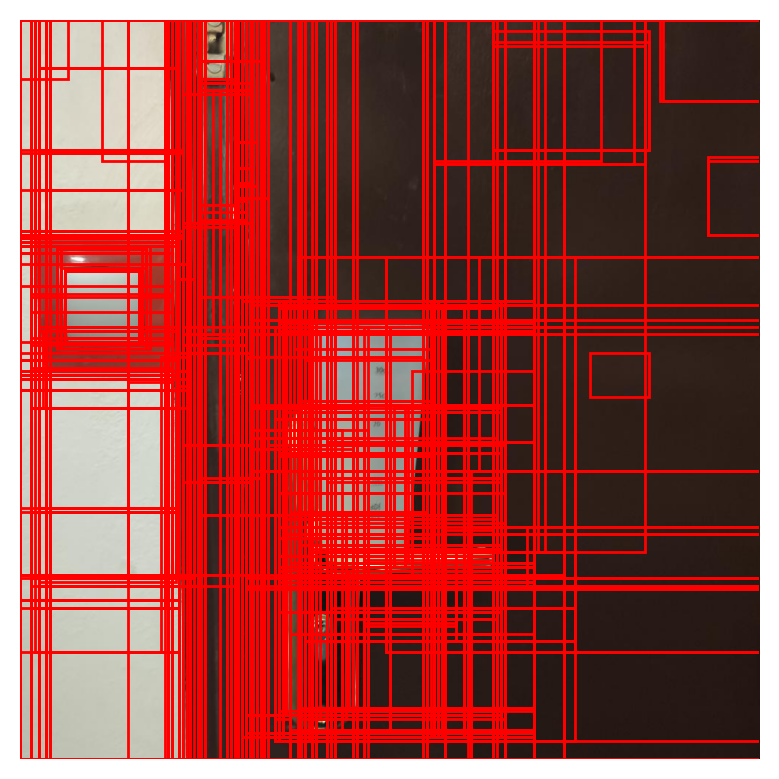

In [40]:
show_boxes(io.imread("data/images/pos/adornipi_pos_005.jpg"), boxes)

In [41]:
# remove boxes with IoU > 0.5
def remove_overlapping_boxes(boxes):
    # create list of bboxes
    bboxes = []
    # iterate over all the region proposals
    for i, rect in enumerate(boxes):
        # draw rectangle for region proposal
        x, y, w, h = rect
        # check if there is an overlap with a previous box
        overlap = False
        for j in range(i):
            if IoU(rect, boxes[j]) > 0.5:
                overlap = True
                break
        if not overlap:
            bboxes.append([x, y, w, h])
    return bboxes

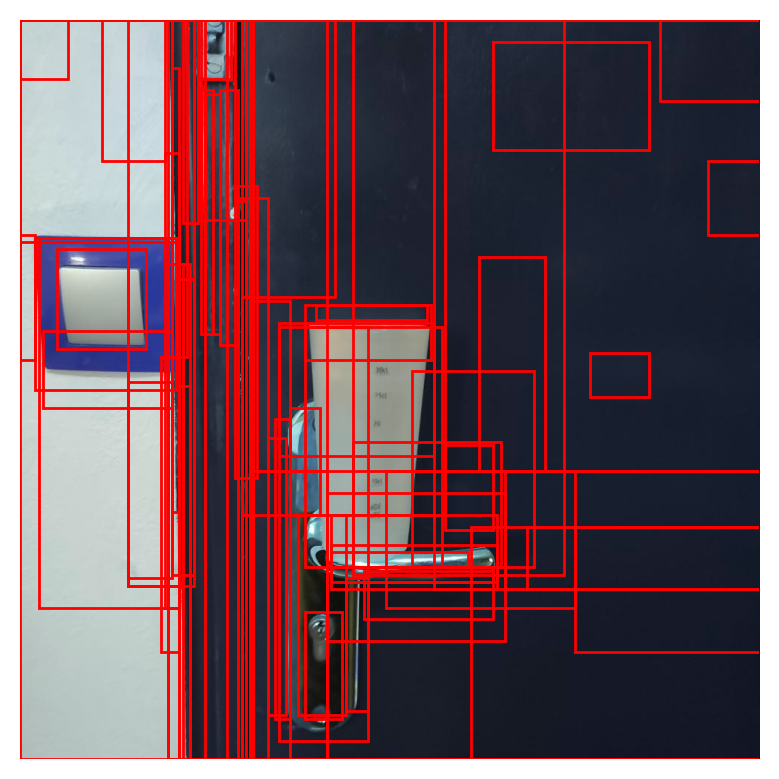

In [42]:
show_boxes(cv2.imread("data/images/pos/adornipi_pos_005.jpg"), remove_overlapping_boxes(boxes))
plt.savefig("images/ss.png", dpi=300)

In [43]:
# remove boxes with aspect ratio too square ( not between 1.5 and 2)
def remove_square_boxes(boxes):
    # create list of bboxes
    bboxes = []
    # iterate over all the region proposals
    for i, rect in enumerate(boxes):
        x, y, w, h = rect
        aspect_ratio = h/w
        if aspect_ratio > 1.5 and aspect_ratio < 2:
            bboxes.append([x, y, w, h])
    return bboxes

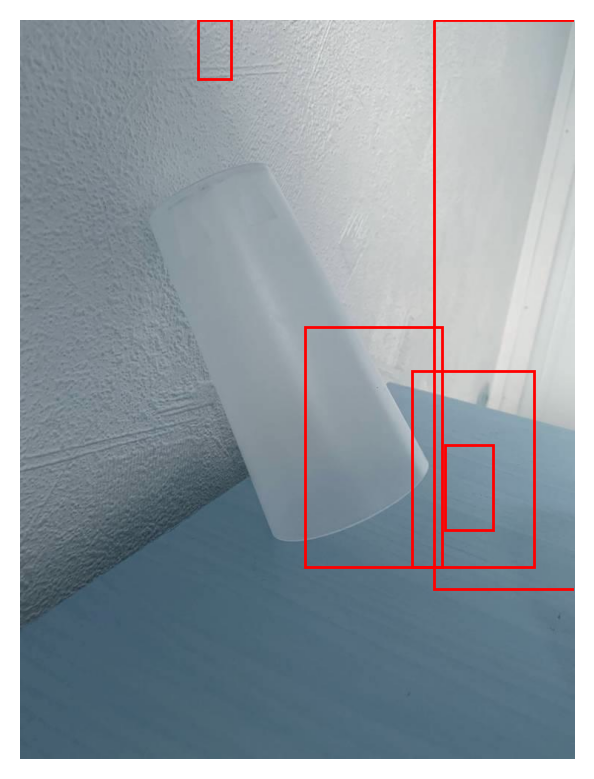

In [49]:
show_boxes(cv2.imread("data/images/pos/ducotete_pos_008.jpg"), remove_square_boxes(remove_overlapping_boxes(boxes)))
plt.savefig("images/ss_bad.png", dpi=300)